<a href="https://colab.research.google.com/github/GAKIZAB/Analyse-des-tendances-de-consommation-sur-les-r-seaux-sociaux/blob/main/Analyse_des_tendances.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [220]:
pip install colorama

In [221]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from colorama import Fore, init
import plotly.express as px

import string
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk import tokenize
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from tqdm.notebook import tqdm
from collections import Counter
from wordcloud import WordCloud

import nltk
nltk.download('punkt')
nltk.download('stopwords')


import plotly.express as px
nltk.download('vader_lexicon')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

# Load Data

In [238]:
data = pd.read_csv('sentimentdataset.csv')
data.head()

,Unnamed: 0.1,Unnamed: 0,Text,Sentiment,Timestamp,User,Platform,Hashtags,Retweets,Likes,Country,Year,Month,Day,Hour
0,0,0,Enjoying a beautiful day at the park! ...,Positive,2023-01-15 12:30:00,User123,Twitter,#Nature #Park,15.0,30.0,USA,2023,1,15,12
1,1,1,Traffic was terrible this morning. ...,Negative,2023-01-15 08:45:00,CommuterX,Twitter,#Traffic #Morning,5.0,10.0,Canada,2023,1,15,8
2,2,2,Just finished an amazing workout! 💪 ...,Positive,2023-01-15 15:45:00,FitnessFan,Instagram,#Fitness #Workout,20.0,40.0,USA,2023,1,15,15
3,3,3,Excited about the upcoming weekend getaway! ...,Positive,2023-01-15 18:20:00,AdventureX,Facebook,#Travel #Adventure,8.0,15.0,UK,2023,1,15,18
4,4,4,Trying out a new recipe for dinner tonight. ...,Neutral,2023-01-15 19:55:00,ChefCook,Instagram,#Cooking #Food,12.0,25.0,Australia,2023,1,15,19


In [239]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0.1  732 non-null    int64  
 1   Unnamed: 0    732 non-null    int64  
 2   Text          732 non-null    object 
 3   Sentiment     732 non-null    object 
 4   Timestamp     732 non-null    object 
 5   User          732 non-null    object 
 6   Platform      732 non-null    object 
 7   Hashtags      732 non-null    object 
 8   Retweets      732 non-null    float64
 9   Likes         732 non-null    float64
 10  Country       732 non-null    object 
 11  Year          732 non-null    int64  
 12  Month         732 non-null    int64  
 13  Day           732 non-null    int64  
 14  Hour          732 non-null    int64  
dtypes: float64(2), int64(6), object(7)
memory usage: 85.9+ KB


In [240]:
data.describe()

,Unnamed: 0.1,Unnamed: 0,Retweets,Likes,Year,Month,Day,Hour
count,732.000000,732.000000,732.000000,732.000000,732.000000,732.000000,732.000000,732.000000
mean,366.464481,369.740437,21.508197,42.901639,2020.471311,6.122951,15.497268,15.521858
std,211.513936,212.428936,7.061286,14.089848,2.802285,3.411763,8.474553,4.113414
min,0.000000,0.000000,5.000000,10.000000,2010.000000,1.000000,1.000000,0.000000
25%,183.750000,185.750000,17.750000,34.750000,2019.000000,3.000000,9.000000,13.000000
50%,366.500000,370.500000,22.000000,43.000000,2021.000000,6.000000,15.000000,16.000000
75%,549.250000,553.250000,25.000000,50.000000,2023.000000,9.000000,22.000000,19.000000
max,732.000000,736.000000,40.000000,80.000000,2023.000000,12.000000,31.000000,23.000000


# Data processing

In [241]:
data = data.drop(columns=['Unnamed: 0.1', 'Unnamed: 0'], axis=1)
# Select all columns of string dtype
object_columns = data.select_dtypes(include=['object']).columns

# 2. Remove leading/trailing spaces from each of those columns
for col in object_columns:
    data[col] = data[col].str.strip()

# Display the count of unique values per column
print(data.nunique())

Text         706
Sentiment    191
Timestamp    683
User         670
Platform       3
Hashtags     692
Retweets      26
Likes         38
Country       33
Year          14
Month         12
Day           31
Hour          22
dtype: int64


In [242]:
df = data.copy()
# Initialize the stemmer and stop words
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

def clean_text(text: str) -> str:

    text = str(text).lower()
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'<.*?>+', '', text)
    text = re.sub(r'\s+', ' ', text.strip())
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'\n', '', text)
    text = re.sub(r'\w*\d\w*', '', text)
    text = re.sub(r'[^\x00-\x7F]+', '', text)


    tokens = word_tokenize(text)
    cleaned_tokens = [
        stemmer.stem(token)
        for token in tokens
        if token not in stop_words
    ]

    return ' '.join(cleaned_tokens)


df['Clean_Text'] = df['Text'].apply(clean_text)

In [243]:
analyzer = SentimentIntensityAnalyzer()

df['Vader_Score'] = df['Clean_Text'].apply(lambda text: analyzer.polarity_scores(text)['compound'])

df['Sentiment'] = df['Vader_Score'].apply(lambda score: 'positive' if score >= 0.05 else ('negative' if score <= -0.05 else 'neutral'))

# Exploratory Data Analysis (EDA)

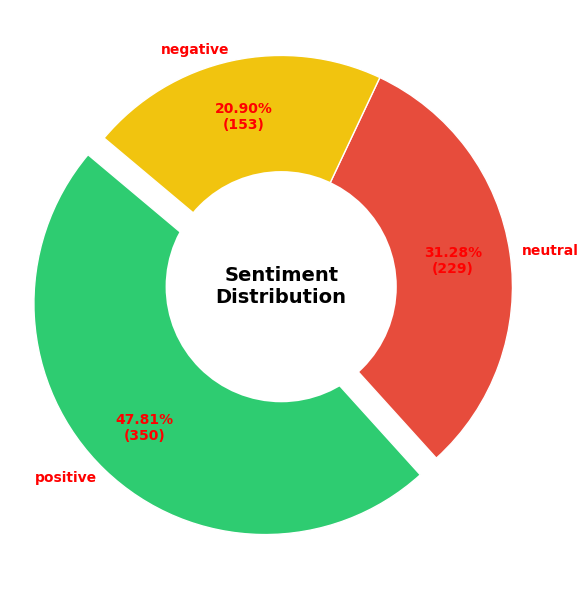

In [228]:
labels2 = list(df['Sentiment'].unique())
sizes2 = list(df['Sentiment'].value_counts())
total = sum(sizes)


explode = [0.1, 0, 0]

colors = ['#2ECC71','#E74C3C', '#F1C40F']


fig, ax = plt.subplots(figsize=(6, 6))
wedges, texts, autotexts = ax.pie(
    sizes2,
    labels=labels2,
    explode=explode,
    colors=colors,
    startangle=140,
    labeldistance=1.05,
    pctdistance=0.75,
    autopct=lambda pct: f"{pct:.2f}%\n({int(pct/100*total)})",
    wedgeprops={'linewidth': 1, 'edgecolor': 'white'}
)


centre_circle = plt.Circle((0, 0), 0.50, fc='white')
ax.add_artist(centre_circle)


for text in texts + autotexts:
    text.set_color('red')
    text.set_fontweight('bold')

ax.text(0, 0, 'Sentiment\nDistribution',
        horizontalalignment='center',
        verticalalignment='center',
        fontsize=14,
        fontweight='bold')

ax.axis('equal')
plt.tight_layout()
plt.show()


In [229]:
# Compute average score per country
df_avg = (
    df
    .groupby('Country')['Vader_Score']
    .mean()
    .reset_index(name='Average_Score')
)


df_labeled = df.copy()
df_labeled['Sentiment'] = df_labeled['Vader_Score'].apply(
    lambda s: 'positive' if s >= 0.05
              else ('negative' if s <= -0.05 else 'neutral')
)

counts = (
    df_labeled
    .groupby(['Country', 'Sentiment'])
    .size()
    .reset_index(name='Count')
)

counts_pivot = counts.pivot(
    index='Country',
    columns='Sentiment',
    values='Count'
).fillna(0).reset_index()


df_plot = df_avg.merge(counts_pivot, on='Country')


sentiment_cols = ['negative', 'neutral', 'positive']
df_plot['Sentiment'] = df_plot[sentiment_cols].idxmax(axis=1)


fig = px.choropleth(
    df_plot,
    locations='Country',
    locationmode='country names',
    color='Sentiment',
    hover_name='Country',
    hover_data={
        'positive': True,
        'neutral': True,
        'negative': True,
        'Average_Score': ':.2f'
    },
    category_orders={'Sentiment': ['negative', 'neutral', 'positive']},
    color_discrete_map={
        'negative': 'red',
        'neutral': 'gold',
        'positive': 'green'
    },
    title='World Map of Sentiment Distribution by Country',
    projection='natural earth'
)

fig.update_geos(showframe=False, showcoastlines=True)
fig.update_layout(
    legend_title_text='Sentiment',
    margin={'r':0,'t':40,'l':0,'b':0}
)

fig.show()

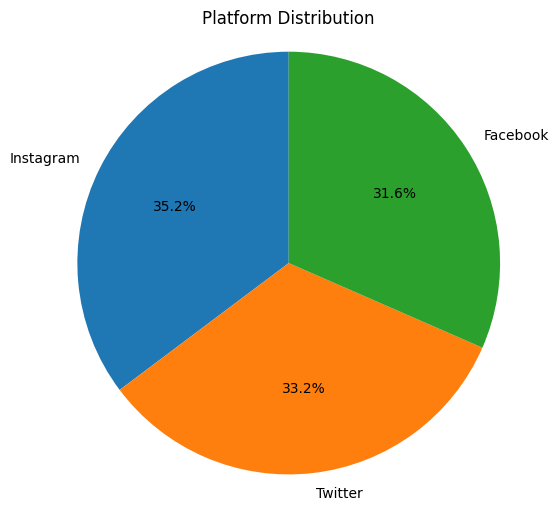

In [230]:
labels = ['Instagram','Twitter','Facebook']
sizes = df['Platform'].value_counts()


plt.figure(figsize=(6, 6))
plt.pie(
    sizes,
    labels=labels,
    autopct='%1.1f%%',
    startangle=90
)
plt.title('Platform Distribution')
plt.axis('equal')
plt.show()

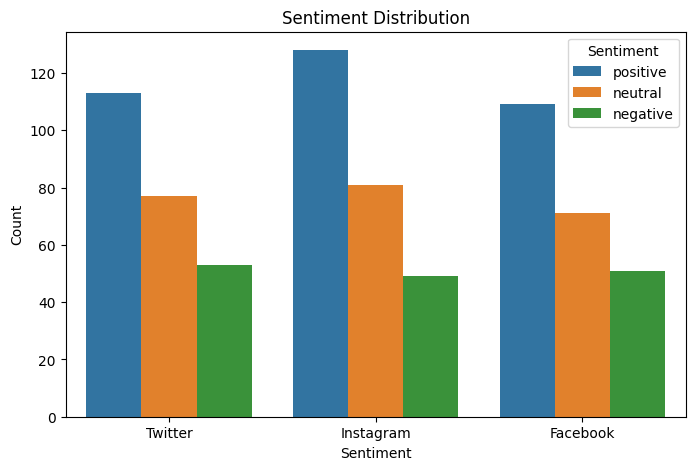

In [231]:
plt.figure(figsize=(8,5))
sns.countplot(x='Platform', hue='Sentiment', data=df)
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

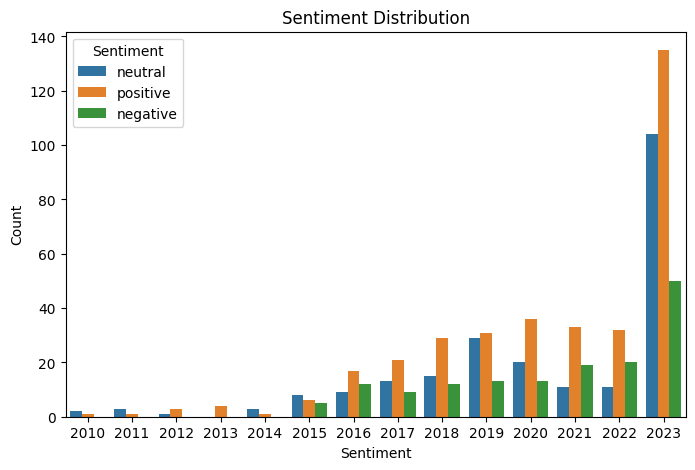

In [232]:
plt.figure(figsize=(8,5))
sns.countplot(x='Year', hue='Sentiment', data=df)
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

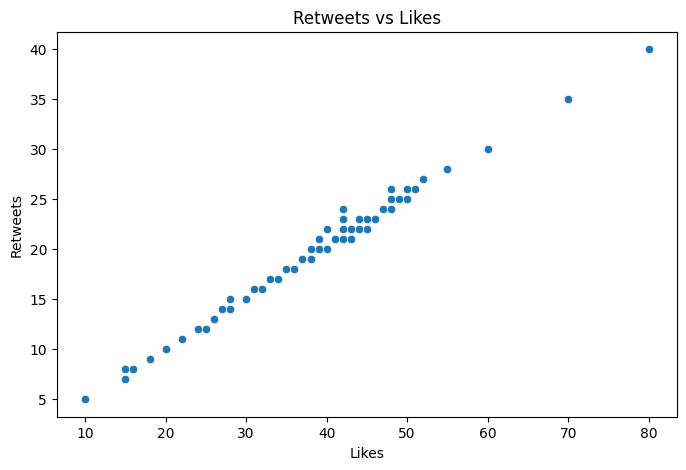

In [233]:
plt.figure(figsize=(8,5))
sns.scatterplot(y='Retweets', x='Likes', data=df)
plt.title('Retweets vs Likes')
plt.show()

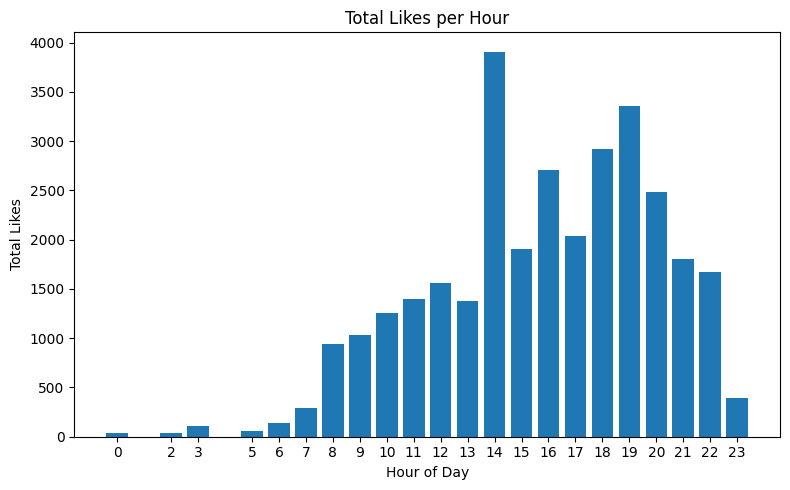

In [234]:
# Aggregate total likes per hour
likes_per_hour = df.groupby('Hour')['Likes'].sum()

# Plot total likes by hour
plt.figure(figsize=(8, 5))
# Access the index (Hours) and values (Likes) of the Series
plt.bar(likes_per_hour.index, likes_per_hour)
plt.xlabel('Hour of Day')
plt.ylabel('Total Likes')
plt.title('Total Likes per Hour')
# Use the index for xticks as well
plt.xticks(likes_per_hour.index)
plt.tight_layout()
plt.show()

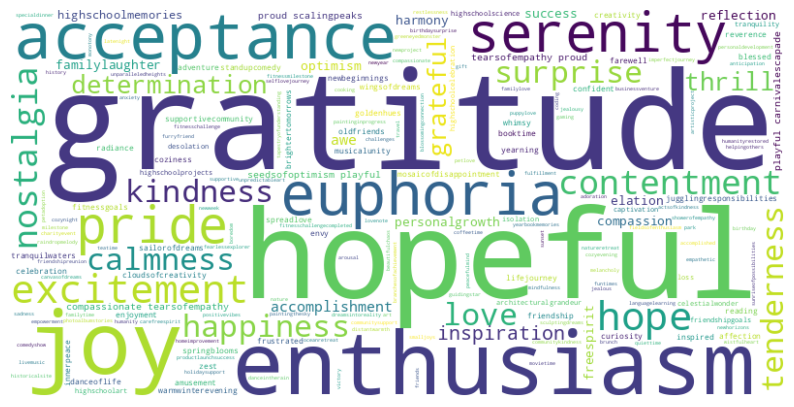

In [244]:
hashtag_strings = df['Hashtags']

df_tags = pd.DataFrame({'raw': hashtag_strings})
df_tags = df_tags.set_index(df.index)

df_tags['split'] = df_tags['raw'].str.split()


df_tags = df_tags.explode('split')
df_tags['tag'] = df_tags['split'].str.lstrip('#').str.lower()
df_tags = df_tags.merge(df[['Sentiment']], left_index=True, right_index=True, how='left')


words = ' '.join(df_tags[df_tags['Sentiment'] == 'positive']['tag'].dropna().tolist())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(words)

# Plot the word cloud
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

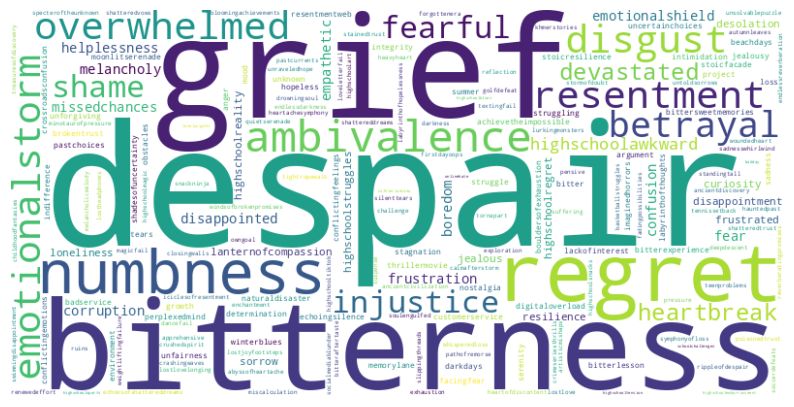

In [245]:
words = ' '.join(df_tags[df_tags['Sentiment'] == 'negative']['tag'].dropna().tolist())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(words)


plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()